<a href="https://colab.research.google.com/github/Sjoneon/Bigdata2/blob/main/LastRealBigData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
#
# 셀 1: 환경 설정 및 라이브러리 설치
#
!pip install geopandas lightgbm

from google.colab import drive
drive.mount('/content/drive')

# 한글 시각화를 위한 나눔고딕 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

print("="*50)
print("✅ 라이브러리 설치 및 폰트 설정이 완료되었습니다.")
print("‼️ 중요: Colab 메뉴에서 [런타임] > [세션 다시 시작]을 눌러주세요.")
print("="*50)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skippin

In [1]:
#
# 셀 2: 라이브러리 임포트 및 기본 설정
#
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import warnings
import glob

# 기본 설정
warnings.filterwarnings('ignore')
plt.rc('font', family='NanumBarunGothic')
plt.rc('axes', unicode_minus=False)
pd.set_option('display.max_columns', None)

print("✅ 라이브러리 임포트 및 기본 설정이 완료되었습니다.")

✅ 라이브러리 임포트 및 기본 설정이 완료되었습니다.


In [2]:
#
# 셀 3: 종합 데이터 로드
#

# --- 파일 경로 설정 ---
base_path = '/content/drive/My Drive/colab_data/'
# --- 설정 끝 ---

# 파일을 안전하게 로드하는 함수
def load_csv_robust(file_path):
    try:
        return pd.read_csv(file_path, encoding='cp949')
    except UnicodeDecodeError:
        return pd.read_csv(file_path, encoding='utf-8')
    except Exception as e:
        print(f"오류: {file_path} 파일 로드 실패 - {e}")
        return None

# 데이터 로드
print("--- 데이터 로드 시작 ---")
df_store = load_csv_robust(base_path + '소상공인시장진흥공단_상가(상권)정보_서울_202503.csv')
df_realty = load_csv_robust(base_path + '서울시 부동산 실거래가 정보.csv')
df_sanggwon_pop = load_csv_robust(base_path + '서울시 상권분석서비스(길단위인구-상권).csv')
df_sanggwon_resident = load_csv_robust(base_path + '서울시 상권분석서비스(상주인구-상권).csv')
print("--- 모든 데이터 로드 완료 ---")

--- 데이터 로드 시작 ---
--- 모든 데이터 로드 완료 ---


In [7]:
#
# 셀 4 (최종 완성본): 데이터 정제 및 표준화
#
print("--- 1단계: 데이터 정제 및 표준화 시작 ---")

# --- 1-1. [핵심 수정] 데이터 정제: 업종명의 불필요한 공백 제거 ---
# 모든 문제의 원인이었던 공백을 .str.strip()으로 제거합니다.
df_store['상권업종중분류명'] = df_store['상권업종중분류명'].str.strip()
print("✅ [1/3] 업종 이름 공백 제거 완료")

# 1-2. 공간 분석을 위한 데이터 준비
seoul_gu_url = "https://raw.githubusercontent.com/southkorea/seoul-maps/master/kostat/2013/json/seoul_municipalities_geo_simple.json"
gdf_seoul_map = gpd.read_file(seoul_gu_url)
gdf_seoul_map.rename(columns={'name': '시군구명'}, inplace=True)

df_store_cleaned = df_store.dropna(subset=['위도', '경도'])
df_store_cleaned = df_store_cleaned[(df_store_cleaned['위도'] > 30) & (df_store_cleaned['경도'] > 120)]
gdf_stores = gpd.GeoDataFrame(
    df_store_cleaned,
    geometry=gpd.points_from_xy(df_store_cleaned.경도, df_store_cleaned.위도),
    crs="EPSG:4326"
)

# 1-3. 공간 결합으로 정확한 시군구명 부여
df_stores_geocoded = gpd.sjoin(gdf_stores, gdf_seoul_map[['시군구명', 'geometry']], how="inner", predicate='within')
print("✅ [2/3] 공간 결합으로 정확한 위치 정보 부여 완료")

# --- 1-4. [핵심 수정] 업종 통합 분류: 실제 데이터 기반으로 재정의 ---
# 보내주신 디버깅 결과를 바탕으로 category_map을 대폭 수정했습니다.
category_map = {
    '카페/디저트': ['비알코올', '제과점'],
    '한식': ['한식', '구내식당·뷔페'],
    '일식/중식/양식': ['서양식', '중식', '일식', '동남아시아', '기타 외국'],
    '주점/바': ['주점'],
    '패스트푸드/치킨': ['패스트푸드', '치킨전문점', '피자전문점'], # 이 항목들은 일반적이므로 유지
    '생활편의': ['세탁', '이용·미용', '편의점', '약국/한약방'], # 이 항목들은 일반적이므로 유지
    '쇼핑': ['시계·귀금속 소매', '섬유·의복·신발 소매', '식료품 소매', '기타 생활용품 소매',
             '의약·화장품 소매', '가전·통신 소매', '장식품 소매', '안경·정밀기기 소매',
             '기타 상품 소매', '중고 상품 소매', '담배 소매', '철물·건설자재 소매',
             '음료 소매', '애완동물·용품 소매', '식물 소매', '가구 소매'],
    '오락/숙박': ['유원지·오락', '오락용품 소매', '기타 숙박', '일반 숙박', '욕탕·신체관리'],
    '교육/서비스': ['인쇄·제품제작', '기타 가정용품 수리', '기타 사업 서비스', '가전제품 수리',
                   '전문 디자인', '청소·방제', '기술 서비스', '사진 촬영', '자동차 수리·세차',
                   '컴퓨터 수리', '기타 전문 과학', '산업용품 대여', '여행사·보조',
                   '기타 교육', '회계·세무', '법무관련', '본사·경영 컨설팅',
                   '교육 지원', '사무 지원', '통신장비 수리', '가정용품 대여',
                   '고용 알선', '모터사이클 소매', '모터사이클 수리', '시설관리',
                   '기타 개인', '운송장비 대여', '시장 조사', '장례식장', '조경·유지'],
    '부동산/의료': ['부동산 서비스', '기타 보건', '수의', '의원', '병원', '자동차 부품 소매']
}

def map_category(category):
    for key, values in category_map.items():
        if category in values:
            return key
    return '기타'
df_stores_geocoded['통합업종'] = df_stores_geocoded['상권업종중분류명'].apply(map_category)
print("✅ [3/3] 실제 데이터 기반 업종 통합 분류 완료")

--- 1단계: 데이터 정제 및 표준화 시작 ---
✅ [1/3] 업종 이름 공백 제거 완료
✅ [2/3] 공간 결합으로 정확한 위치 정보 부여 완료
✅ [3/3] 실제 데이터 기반 업종 통합 분류 완료


In [6]:
#
# 셀 4.5 (디버깅용): 실제 업종 이름 확인
#

print("--- 실제 데이터에 포함된 '상권업종중분류명' 목록 ---")
# 실제 데이터에 어떤 업종 이름들이 있는지 모두 출력합니다.
unique_categories = df_stores_geocoded['상권업종중분류명'].unique()
print(unique_categories)


print("\n\n--- 우리가 만든 '통합업종' 분류 결과 ---")
# 우리가 만든 카테고리별로 몇 개의 점포가 분류되었는지 확인합니다.
# 여기서 '카페/디저트'가 없거나 수치가 0으로 나오면, 이름이 일치하지 않은 것입니다.
print(df_stores_geocoded['통합업종'].value_counts())

--- 실제 데이터에 포함된 '상권업종중분류명' 목록 ---
['비알코올 ' '부동산 서비스' '한식' '시계·귀금속 소매' '섬유·의복·신발 소매' '식료품 소매' '기타 생활용품 소매'
 '이용·미용' '기타 가정용품 수리' '인쇄·제품제작' '의약·화장품 소매' '세탁' '유원지·오락' '가전·통신 소매'
 '장식품 소매' '기타 간이' '주점' '종합 소매' '기타 사업 서비스' '가전제품 수리' '전문 디자인' '청소·방제'
 '기술 서비스' '안경·정밀기기 소매' '광고' '서양식' '사진 촬영' '자동차 수리·세차' '중식' '컴퓨터 수리'
 '기타 전문 과학' '오락용품 소매' '산업용품 대여' '기타 상품 소매' '여행사·보조' '중고 상품 소매' '스포츠 서비스'
 '기타 교육' '회계·세무' '법무관련 ' '담배 소매' '본사·경영 컨설팅' '교육 지원' '철물·건설자재 소매' '일식'
 '사무 지원' '통신장비 수리' '가정용품 대여' '음료 소매' '고용 알선' '모터사이클 소매' '기타 숙박' '일반 숙박'
 '욕탕·신체관리' '동남아시아' '구내식당·뷔페' '애완동물·용품 소매' '시설관리' '기타 보건' '수의' '식물 소매'
 '기타 개인' '연료 소매' '도서관·사적지' '일반 교육' '운송장비 대여' '가구 소매' '모터사이클 수리' '의원' '병원'
 '자동차 부품 소매' '시장 조사' '장례식장 ' '조경·유지' '기타 외국']


--- 우리가 만든 '통합업종' 분류 결과 ---
통합업종
기타    538942
Name: count, dtype: int64


In [11]:
#
# 셀 5: 최종 분석 데이터셋 구축
#
print("--- 2단계: 최종 분석 데이터셋 구축 시작 ---")

# 1. 시군구별, 통합업종별 점포 수 계산
store_counts_by_category = df_stores_geocoded.groupby(['시군구명_right', '통합업종']).size()
df_final = store_counts_by_category.unstack().fillna(0).astype(int)
df_final.index.name = '시군구명'
print("✅ [1/2] 시군구-업종별 점포 수 집계 완료")

# 2. 입력 변수(Feature) 결합
seoul_gu_list = df_final.index.tolist()
# 부동산
if 'df_realty' in locals() and df_realty is not None:
    df_realty_cleaned = df_realty.dropna(subset=['건물면적(㎡)', '물건금액(만원)'])
    df_realty_cleaned = df_realty_cleaned[df_realty_cleaned['건물면적(㎡)'] > 0]
    df_realty_cleaned['평당가격'] = df_realty_cleaned['물건금액(만원)'] / (df_realty_cleaned['건물면적(㎡)'] / 3.3)
    realty_price = df_realty_cleaned.groupby('자치구명')['평당가격'].mean().reset_index(name='평균평당가(만원)')
    realty_price.rename(columns={'자치구명': '시군구명'}, inplace=True)
    df_final = pd.merge(df_final.reset_index(), realty_price, on='시군구명', how='left').set_index('시군구명')

# 유동인구 및 상주인구
def get_gu_from_sanggwon(name, gu_list):
    for gu in gu_list:
        if gu in name: return gu
    return None
if 'df_sanggwon_pop' in locals() and df_sanggwon_pop is not None:
    df_sanggwon_pop['시군구명'] = df_sanggwon_pop['상권_코드_명'].apply(lambda x: get_gu_from_sanggwon(x, seoul_gu_list))
    sanggwon_pop_agg = df_sanggwon_pop.groupby('시군구명')['총_유동인구_수'].sum().reset_index()
    df_final = pd.merge(df_final.reset_index(), sanggwon_pop_agg, on='시군구명', how='left').set_index('시군구명')
if 'df_sanggwon_resident' in locals() and df_sanggwon_resident is not None:
    df_sanggwon_resident['시군구명'] = df_sanggwon_resident['상권_코드_명'].apply(lambda x: get_gu_from_sanggwon(x, seoul_gu_list))
    sanggwon_resident_agg = df_sanggwon_resident.groupby('시군구명')['총_상주인구_수'].sum().reset_index()
    df_final = pd.merge(df_final.reset_index(), sanggwon_resident_agg, on='시군구명', how='left').set_index('시군구명')

df_final.fillna(0, inplace=True)
print("✅ [2/2] 부동산, 인구 데이터 결합 완료")

# --- 최종 정리 ---
if '기타' in df_final.columns:
    df_final = df_final.drop(columns=['기타'])

print("\n--- ✅ 모든 데이터 준비 완료 ---")
display(df_final.head())

--- 2단계: 최종 분석 데이터셋 구축 시작 ---
✅ [1/2] 시군구-업종별 점포 수 집계 완료
✅ [2/2] 부동산, 인구 데이터 결합 완료

--- ✅ 모든 데이터 준비 완료 ---


,교육/서비스,부동산/의료,생활편의,쇼핑,오락/숙박,일식/중식/양식,주점/바,카페/디저트,한식,평균평당가(만원),총_유동인구_수,총_상주인구_수
시군구명,,,,,,,,,,,,
강남구,22672,6363,3101,7733,1854,2555,1274,2143,4450,8668.013342,111798570.0,146058.0
강동구,3546,2045,1574,3124,993,567,624,714,1803,4772.013645,159683307.0,441652.0
강북구,2391,1152,1227,2265,826,367,613,534,1644,2262.618995,34897691.0,39392.0
강서구,6832,2516,2338,4071,1334,955,994,1165,2836,3147.651474,70798936.0,201666.0
관악구,3348,1503,1534,2453,1267,639,831,700,1839,2983.718858,208159233.0,555538.0


In [15]:
#
# 셀 6 (수정): 데이터 준비 및 차원 축소 (PCA)
#
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1. 모델의 입력 변수(X)와 목표 변수(y)를 정의합니다.
# (y는 다음 셀에서 업종별로 정의하므로, 여기서는 X만 준비합니다.)
X_features = df_final[['평균평당가(만원)', '총_유동인구_수', '총_상주인구_수']]

# 2. 데이터 스케일링
# 각 변수의 크기가 달라 발생하는 왜곡을 막기 위해 표준화를 진행합니다.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)
print("✅ 입력 변수 스케일링 완료")

# 3. PCA를 통한 차원 축소
# 3개의 변수를 2개의 주성분(Principal Components)으로 압축합니다.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
print("✅ PCA 차원 축소 완료 (3개 -> 2개)")

# PCA 결과 확인
print("\n--- PCA 변환 후 데이터 ---")
df_pca = pd.DataFrame(X_pca, index=df_final.index, columns=['주성분_1', '주성분_2'])
display(df_pca.head())

# 각 주성분이 원래 변수들을 얼마나 설명하는지 확인
print("\n--- 주성분별 설명력 ---")
print(f"주성분 1: {pca.explained_variance_ratio_[0]:.2f}, 주성분 2: {pca.explained_variance_ratio_[1]:.2f}")
print(f"총 설명력: {pca.explained_variance_ratio_.sum():.2f}")

✅ 입력 변수 스케일링 완료
✅ PCA 차원 축소 완료 (3개 -> 2개)

--- PCA 변환 후 데이터 ---


,주성분_1,주성분_2
시군구명,,
강남구,0.910077,2.588568
강동구,3.325983,0.539850
강북구,-0.317196,-1.228822
강서구,0.964074,-0.624399
관악구,4.680629,-0.333721



--- 주성분별 설명력 ---
주성분 1: 0.65, 주성분 2: 0.33
총 설명력: 0.99


In [18]:
#
# 셀 7 (최종 수정): 정확도(R²) 출력 기능 추가
#
from sklearn.metrics import r2_score

# 0. 분석할 핵심 업종 리스트 정의
target_categories = ['카페/디저트', '한식', '패스트푸드/치킨', '생활편의', '쇼핑', '주점/바']

# 1. 최종 결과를 저장할 빈 데이터프레임 생성
df_report_linear = pd.DataFrame(index=df_final.index)

# 2. 각 업종별로 선형 회귀 모델링을 자동 반복 실행
print("--- 업종별 선형회귀 분석 시작 ---")
for category in target_categories:
    if category in df_final.columns:
        print(f"\n[{category}] 업종 분석 중...")

        # 2-1. 데이터 준비
        X_input = df_pca
        y_actual = df_final[category] # 실제값 (원래 스케일)
        y_log = np.log1p(y_actual)    # 로그 변환된 타겟

        # 2-2. 선형 회귀 모델 학습
        linear_model = LinearRegression()
        linear_model.fit(X_input, y_log)

        # 2-3. 예측 및 원래 값으로 복원
        log_predictions = linear_model.predict(X_input)
        predictions = np.expm1(log_predictions).astype(int)

        # --- [추가] 모델 정확도(R²) 계산 및 출력 ---
        # R²는 원래 스케일의 값으로 계산해야 더 직관적입니다.
        r2 = r2_score(y_actual, predictions)
        print(f"  -> 모델 설명력(R²): {r2:.2f} ({r2:.2%})")

        # 2-4. 결과 저장
        df_report_linear[f'{category}_실제'] = y_actual
        df_report_linear[f'{category}_적정'] = predictions
        df_report_linear[f'{category}_포화도'] = y_actual - predictions

print("\n--- ✅ 업종별 선형회귀 분석 및 최종 요약 테이블 완성 ---")
display(df_report_linear.head())

--- 업종별 선형회귀 분석 시작 ---

[카페/디저트] 업종 분석 중...
  -> 모델 설명력(R²): 0.43 (42.94%)

[한식] 업종 분석 중...
  -> 모델 설명력(R²): 0.30 (29.99%)

[생활편의] 업종 분석 중...
  -> 모델 설명력(R²): 0.23 (23.21%)

[쇼핑] 업종 분석 중...
  -> 모델 설명력(R²): 0.34 (34.38%)

[주점/바] 업종 분석 중...
  -> 모델 설명력(R²): 0.27 (26.66%)

--- ✅ 업종별 선형회귀 분석 및 최종 요약 테이블 완성 ---


,카페/디저트_실제,카페/디저트_적정,카페/디저트_포화도,한식_실제,한식_적정,한식_포화도,생활편의_실제,생활편의_적정,생활편의_포화도,쇼핑_실제,쇼핑_적정,쇼핑_포화도,주점/바_실제,주점/바_적정,주점/바_포화도
시군구명,,,,,,,,,,,,,,,
강남구,2143,1725,418,4450,2985,1465,3101,1875,1226,7733,5526,2207,1274,976,298
강동구,714,1010,-296,1803,2331,-528,1574,1816,-242,3124,3472,-348,624,894,-270
강북구,534,593,-59,1644,1573,71,1227,1071,156,2265,2452,-187,613,533,80
강서구,1165,712,453,2836,1801,1035,2338,1287,1051,4071,2760,1311,994,638,356
관악구,700,807,-107,1839,2119,-280,1534,1842,-308,2453,2839,-386,831,882,-51


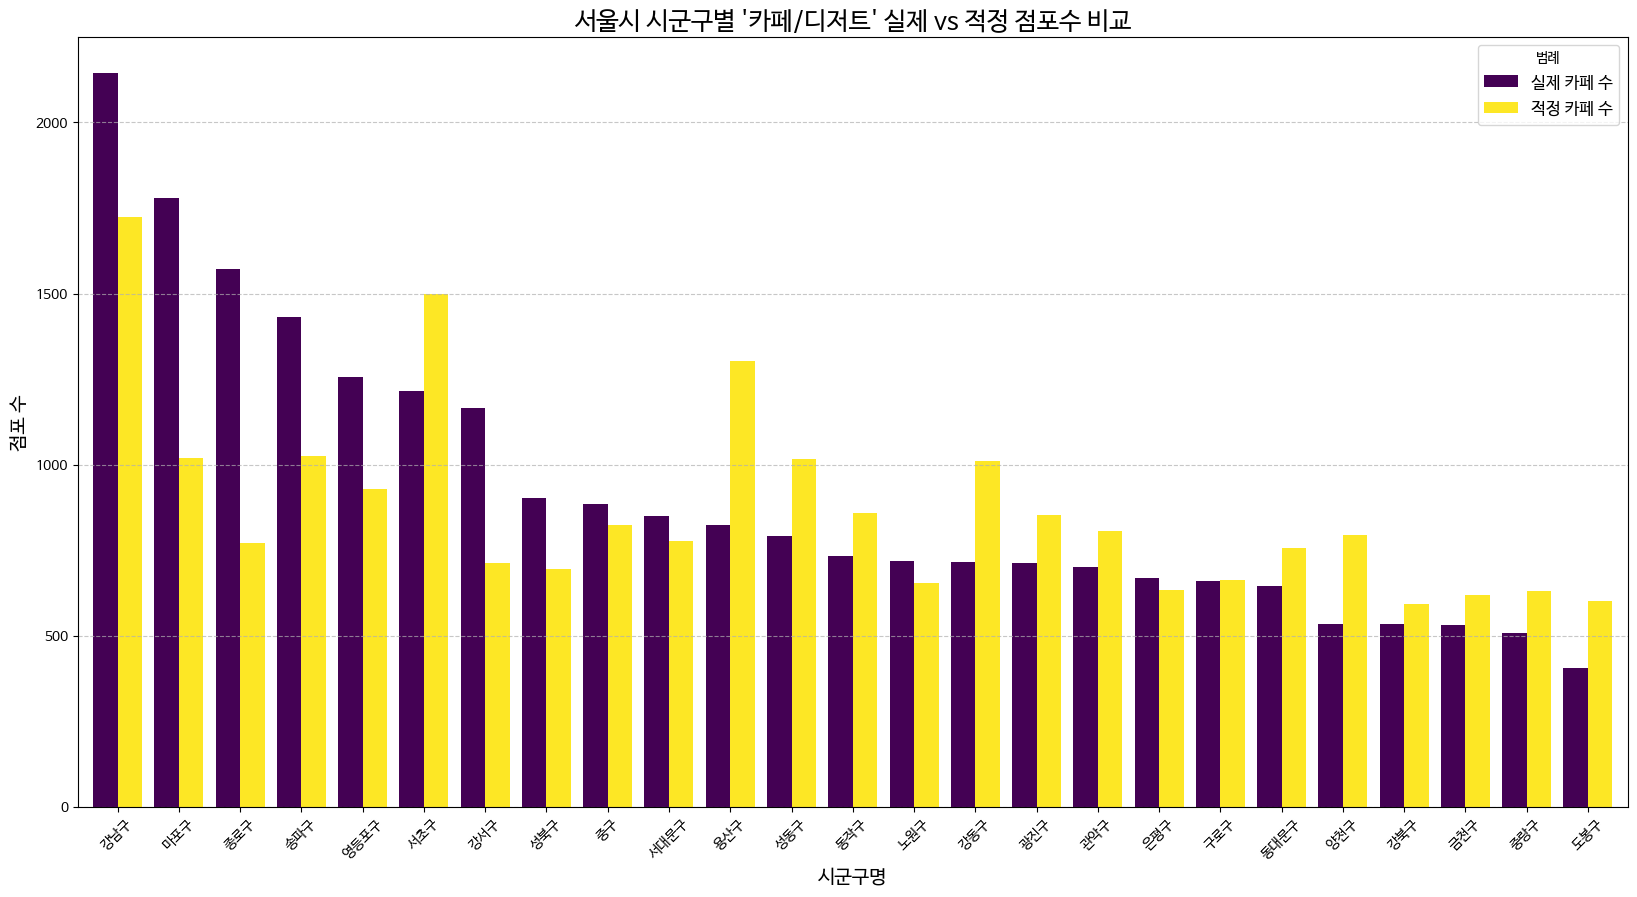

--- '카페/디저트' 성장 잠재력 지역 TOP 5 ---


,카페/디저트_실제,카페/디저트_적정,카페/디저트_포화도,한식_실제,한식_적정,한식_포화도,생활편의_실제,생활편의_적정,생활편의_포화도,쇼핑_실제,쇼핑_적정,쇼핑_포화도,주점/바_실제,주점/바_적정,주점/바_포화도
시군구명,,,,,,,,,,,,,,,
용산구,823,1304,-481,1401,2424,-1023,683,1414,-731,2978,4608,-1630,648,741,-93
강동구,714,1010,-296,1803,2331,-528,1574,1816,-242,3124,3472,-348,624,894,-270
서초구,1214,1500,-286,2305,2612,-307,1478,1473,5,5373,5166,207,557,780,-223
양천구,535,795,-260,1231,1825,-594,1129,1139,-10,2142,3133,-991,391,581,-190
성동구,792,1016,-224,1674,2117,-443,997,1300,-303,2320,3772,-1452,502,670,-168


In [17]:
#
# 셀 8 (수정): '카페/디저트' 업종 상세 분석 및 시각화 (Bar Plot)
#

# 1. 시각화할 데이터 선택
target_category_to_view = '카페/디저트'
actual_col = f'{target_category_to_view}_실제'
optimal_col = f'{target_category_to_view}_적정'
df_view = df_report_linear[[actual_col, optimal_col]].copy()
df_view.rename(columns={actual_col: '실제 카페 수', optimal_col: '적정 카페 수'}, inplace=True)

# 2. 실제 점포수가 많은 순으로 정렬
df_view = df_view.sort_values(by='실제 카페 수', ascending=False)

# 3. Bar Plot 시각화
df_view.plot(kind='bar', figsize=(20, 10), width=0.8, colormap='viridis')
plt.title(f"서울시 시군구별 '{target_category_to_view}' 실제 vs 적정 점포수 비교", fontsize=18)
plt.ylabel('점포 수', fontsize=14)
plt.xlabel('시군구명', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='범례', fontsize=12)
plt.show()

# 4. 포화도 지수가 낮은(성장 잠재력 높은) 지역 확인
print(f"--- '{target_category_to_view}' 성장 잠재력 지역 TOP 5 ---")
display(df_report_linear.sort_values(by=f'{target_category_to_view}_포화도').head())